### we will start by patching our notebook to be optimized to run with intel-based CPUs 
### by doing that we can make our sklearn models run much faster, and as we are dealing with a large data set it is very important 
### it is a good way to prevent Kernel crushes by reducing ram usage 

In [42]:
from sklearnex import patch_sklearn 
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


### importing needed libaries 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import time
%matplotlib inline

### importing our data and cleaning the data 
### cleaning the data includes turning any categorical data into numerical data to use with regression models 

In [43]:
df = pd.read_csv('/Users/dimagoroh/Desktop/data_vis/big_file.csv', low_memory=False)

In [44]:
df=df.drop(['downloadSpeed', 'uploadSpeed'], axis=1)
df = df.dropna()

In [46]:
df["time"] = df['date'].astype(str) + " " +df["hour"]

In [47]:
df['time'] = pd.to_datetime(df["time"])
df['hour']=df['time'].dt.hour
df['minute']=df['time'].dt.minute
df['hour']=df['time'].dt.hour
df['second']=df['time'].dt.second
df['month']=df['time'].dt.month
df['day']=df['time'].dt.day
df['postal_code'] = df['postal_code'].astype(str)
df['region_code'] = df['postal_code'].str[:1]


conditions = [
    (df['region_code'] == "8"),
    (df['region_code'] == "1"),
     (df['region_code'] == "2"),
    (df['region_code'] == "4") 
]

values = ['Barcelona','Girona','Lleida','Tarragona']

df['region_code'] = np.select(conditions, values)

In [ ]:
### checking our data correlation 

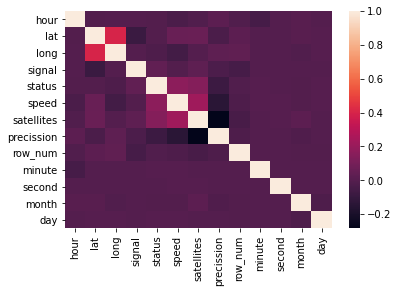

In [49]:
sns.heatmap(df.corr());


### choosing a network to predict  

In [51]:

df.groupby(['network'])['network'].count().sort_values(ascending=False).head(10)
filtered_df = df[df['network'] == 'yoigo'] 

network
movistar                     4338883
orange                       2608597
vodafone                     2492137
yoigo                         336820
Telefonica Moviles Espana      45523
Orange SP                      45080
Eroski Movil                   35682
TICAE                          22865
France Telcom Espana SA        22413
Lowi                           17663
Name: network, dtype: int64

<class 'pandas.core.frame.DataFrame'>
Int64Index: 336820 entries, 14 to 11744866
Data columns (total 25 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   date           336820 non-null  object        
 1   hour           336820 non-null  int64         
 2   lat            336820 non-null  float64       
 3   long           336820 non-null  float64       
 4   signal         336820 non-null  int64         
 5   network        336820 non-null  object        
 6   operator       336820 non-null  object        
 7   status         336820 non-null  int64         
 8   description    336820 non-null  object        
 9   net            336820 non-null  object        
 10  speed          336820 non-null  float64       
 11  satellites     336820 non-null  float64       
 12  precission     336820 non-null  float64       
 13  provider       336820 non-null  object        
 14  activity       336820 non-null  object        
 1

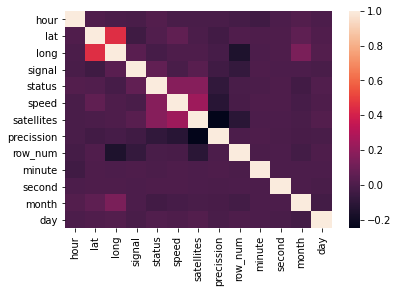

In [56]:
sns.heatmap(filtered_df.corr());


In [57]:
filtered_df["time"] = pd.to_numeric(filtered_df["time"], downcast="float")
filtered_df=filtered_df.drop(['date'], axis=1)
filtered_df=filtered_df.drop(['row_num'], axis=1)
filtered_df=filtered_df.drop(['town_name'], axis=1)
filtered_df=filtered_df.drop(['description','operator'], axis=1)
filtered_df=filtered_df.drop(['position_geom'], axis=1)
filtered_df.info()
filtered_df=filtered_df.drop(['second','minute','postal_code'], axis=1)

<ipython-input-57-e18fc88f7671>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["time"] = pd.to_numeric(filtered_df["time"], downcast="float")


In [64]:
filtered_df=filtered_df.drop(['second','minute','postal_code'], axis=1)

### creating dummies for our categorical variables  

In [65]:
categorical = ['net','provider','activity','region_code']


In [66]:
df_dummies = pd.get_dummies(filtered_df, columns=categorical)


In [67]:
filtered_df=df_dummies


<class 'pandas.core.frame.DataFrame'>
Int64Index: 336820 entries, 14 to 11744866
Data columns (total 28 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   hour                   336820 non-null  int64  
 1   lat                    336820 non-null  float64
 2   long                   336820 non-null  float64
 3   signal                 336820 non-null  int64  
 4   network                336820 non-null  object 
 5   status                 336820 non-null  int64  
 6   speed                  336820 non-null  float64
 7   satellites             336820 non-null  float64
 8   precission             336820 non-null  float64
 9   time                   336820 non-null  float32
 10  month                  336820 non-null  int64  
 11  day                    336820 non-null  int64  
 12  net_2G                 336820 non-null  uint8  
 13  net_3G                 336820 non-null  uint8  
 14  net_4G                 336820 non

In [68]:
filtered_df.columns

Index(['hour', 'lat', 'long', 'signal', 'network', 'status', 'speed',
       'satellites', 'precission', 'time', 'month', 'day', 'net_2G', 'net_3G',
       'net_4G', 'provider_fused', 'provider_gps', 'provider_network',
       'activity_IN_VEHICLE', 'activity_ON_BICYCLE', 'activity_ON_FOOT',
       'activity_STILL', 'activity_TILTING', 'activity_UNKNOWN',
       'region_code_Barcelona', 'region_code_Girona', 'region_code_Lleida',
       'region_code_Tarragona'],
      dtype='object')

In [70]:
filtered_df.shape

(336820, 28)

In [72]:
from sklearn.model_selection import train_test_split


In [73]:
#fetures=['hour', 'lat', 'long']
#fetures=['hour', 'lat', 'long', 'signal', 'status', 'satellites',
#       'precission', 'net_2G', 'net_3G', 'net_4G',
#        'activity_IN_VEHICLE', 'activity_ON_BICYCLE',
#        'activity_ON_FOOT', 'activity_STILL', 'activity_TILTING',
#        'activity_UNKNOWN']
fetures=[ 'hour','lat', 'long', 'signal', 'status',
       'satellites', 'precission', 'month', 'day', 'net_2G', 'net_3G',
       'net_4G', 'provider_disabled', 'provider_fused', 'provider_gps',
       'provider_local_database', 'provider_network', 'activity_IN_VEHICLE',
       'activity_ON_BICYCLE', 'activity_ON_FOOT', 'activity_STILL',
       'activity_TILTING', 'activity_UNKNOWN', 'region_code_Barcelona',
       'region_code_Girona', 'region_code_Lleida', 'region_code_Tarragona']

In [74]:
fetures=[ 'hour', 'lat', 'long', 'signal', 'status','net_2G', 'net_3G','net_4G','satellites', 'precission', 'month', 'activity_IN_VEHICLE',
          'activity_ON_BICYCLE', 'activity_ON_FOOT', 'activity_STILL','activity_TILTING', 'region_code_Barcelona','region_code_Girona', 
          'region_code_Lleida', 'region_code_Tarragona']

In [75]:
target=['speed']

### preparing our data to test and train 

In [77]:
df_train, df_test = train_test_split(filtered_df, test_size=0.2)
df_train=df_train[fetures+target]
df_test=df_test[fetures+target]
x_train = df_train[fetures].to_numpy()
x_test = df_test[fetures].to_numpy()
x_test.shape, x_train.shape


((67364, 20), (269456, 20))

In [78]:
y_train = df_train['speed']
y_test = df_test['speed']



# <b>choosing the correct algoritem </b>
## <b>Linear Regression is very easy and fast to implement but-
### it Assumes linear relationship between dependent and independent variables, which is incorrect in most cases and especialy as we saw from the heat map at our data set 
### Sensitive to outliers
### If the number of observations are less, it leads to over fitting, it starts considering noise.

## <b>Ridge Regression-</b>
### Trades variance for bias (i.e. in presence of co-linearity, it is worth to have biased results, in order to lower the variance.)
### Prevents over fitting

## <b>LASSO Regression-</b>
### Selected features will be highly biased.
### For n<<p (n-number of data points, p-number of features), LASSO selects at most n features.
### LASSO will select only one feature from a group of correlated features, the selection is arbitrary in nature.
### For different boot strapped data, the feature selected can be very different.
### Prediction performance is worse than Ridge regression.

## <b>Elastic Net Regression-</b>
### Computationally more expensive than LASSO or Ridge.


# Ridge  Ridge

In [79]:
# make a prediction with a ridge regression model on the dataset

from sklearn.linear_model import Ridge

# define model
model = Ridge(alpha=0.01)
# fit model
model.fit(x_train,y_train)


Ridge(alpha=0.01)

In [80]:
coeff_df_Ridge = pd.DataFrame(model.coef_,fetures,columns=['Coefficient'])
coeff_df_Ridge


,Coefficient
hour,-0.047557
lat,10.126900
long,-1.557001
signal,-0.042633
status,3.303922
net_2G,3.409569
net_3G,0.068932
net_4G,-3.478519
satellites,0.959877
precission,-0.027087


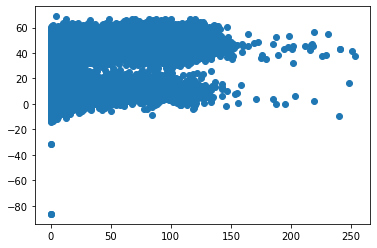

In [81]:
predictions = model.predict(x_test)
plt.scatter(y_test,predictions)

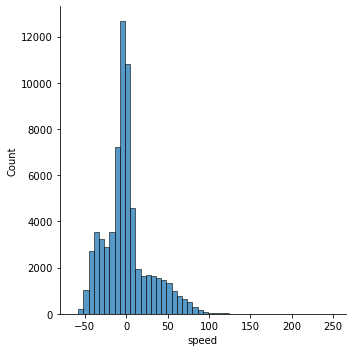

In [82]:
sns.displot((y_test-predictions),bins=50);

In [83]:
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))
metrics.explained_variance_score(y_test, predictions)

MAE: 19.80929976057418
MSE: 781.5990971455595
RMSE: 27.957093860871154


0.3552512874304192

### picking the best alpha value

In [114]:
from sklearn.metrics import r2_score

def train_eval(alpha):
    model=Ridge(alpha=alpha)
    model.fit(x_train,y_train)
    predictions = model.predict(x_test)
    r2 = r2_score(y_test, predictions)
    var_score = metrics.explained_variance_score(y_test, predictions)
    return r2, var_score

for alpha in [0.0001, 0.05, 0.2, 0.3, 0.4]:
    r2, var_score = train_eval(alpha)
    print(f'r2: {r2}')
    print(f'var_score:{var_score}')

ValueError: could not convert string to float: 'STATE_EMERGENCY_ONLY'

# Lasso

In [85]:
y_train.shape, y_test.shape

((269456,), (67364,))

In [86]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso

In [87]:
# stndrd= StandardScaler()

In [88]:
# x_train=stndrd.fit_transform(x_train)
# x_test=stndrd.transform(x_test)

In [89]:
lasso=Lasso(alpha=0.01)
lasso.fit(x_train,y_train)
print(lasso.intercept_)

-379.80032158092916


In [90]:
coeff_df = pd.DataFrame(lasso.coef_,fetures,columns=['Coefficient'])
coeff_df


,Coefficient
hour,-0.047976
lat,9.153648
long,-1.211848
signal,-0.044300
status,3.253379
net_2G,3.290796
net_3G,0.000000
net_4G,-3.567852
satellites,0.965699
precission,-0.026723


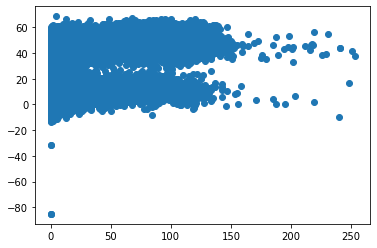

In [91]:
predictions = lasso.predict(x_test)
plt.scatter(y_test,predictions)

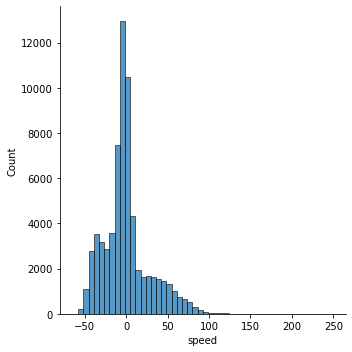

In [92]:
sns.displot((y_test-predictions),bins=50);


In [93]:

from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))
metrics.explained_variance_score(y_test, predictions)

MAE: 19.801831831856592
MSE: 781.7110314854434
RMSE: 27.959095684328624


0.3551588791033582

In [94]:
#checking for the best alpha
from sklearn.metrics import r2_score

def train_eval(alpha):
    lasso=Lasso(alpha=alpha)
    lasso.fit(x_train,y_train)
    predictions = lasso.predict(x_test)
    r2 = r2_score(y_test, predictions)
    var_score = metrics.explained_variance_score(y_test, predictions)
    return r2, var_score

for alpha in [0.001, 0.05, 0.2, 0.3, 0.4]:
    r2, var_score = train_eval(alpha)
    print(f'r2: {r2}')
    print(f'var_score:{var_score}')
    

r2: 0.3552376810476753
var_score:0.35524727529823763
r2: 0.3541621779738018
var_score:0.35417143834782794
r2: 0.3512148350925127
var_score:0.3512242528449713
r2: 0.34999492458031023
var_score:0.35000461317712417
r2: 0.34900153098386544
var_score:0.34901146957333307


# linear_model

In [95]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(1)
x_train_poli=poly.fit_transform(x_train)
model_lin_reg = LinearRegression()
model_lin_reg.fit(x_train,x_train)


LinearRegression()

In [96]:
X_test_poli=poly.transform(x_test)

In [97]:
print(model_lin_reg.intercept_)

[  0.          91.97631701   0.           0.           0.
   0.           0.          -0.71856498   0.          45.9881585
 -11.49703963   0.           0.           0.35928249   0.
   0.           0.           0.17964124   0.17964124  -0.17964124]


In [98]:
coeff_df = pd.DataFrame(model_lin_reg.coef_,fetures,columns=['Coefficient'])
coeff_df


ValueError: Shape of passed values is (20, 20), indices imply (20, 1)

In [51]:
predictions = model_lin_reg.predict(X_test_poli)

plt.scatter(y_test,predictions)


ValueError: X has 406 features, but LinearRegression is expecting 27 features as input

In [99]:
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))
metrics.explained_variance_score(y_test, predictions)

MAE: 19.801831831856592
MSE: 781.7110314854434
RMSE: 27.959095684328624


0.3551588791033582

# ElasticNet

In [101]:
from sklearn.linear_model import ElasticNet
# define model
model = ElasticNet(alpha=0.001, l1_ratio=0.1)
# fit model
model.fit(x_train,y_train)

ElasticNet(alpha=0.001, l1_ratio=0.1)

In [102]:
print(model.intercept_)

-395.268672041878


MAE: 19.81471954478773
MSE: 781.667036881926
RMSE: 27.95830890597509


0.3551951458728453

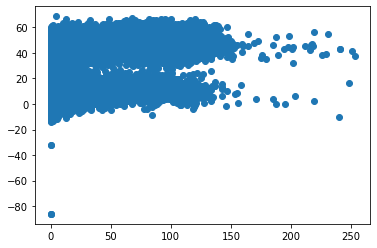

In [103]:
coeff_df = pd.DataFrame(model.coef_,fetures,columns=['Coefficient'])
coeff_df
predictions = model.predict(x_test)
plt.scatter(y_test,predictions)
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))
metrics.explained_variance_score(y_test, predictions)

In [104]:
coeff_df = pd.DataFrame(model.coef_,fetures,columns=['Coefficient'])
coeff_df


,Coefficient
hour,-0.048029
lat,9.535419
long,-1.367897
signal,-0.043560
status,3.307676
net_2G,3.812435
net_3G,0.479778
net_4G,-3.100629
satellites,0.966827
precission,-0.027001


In [105]:
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))
metrics.explained_variance_score(y_test, predictions)

MAE: 19.81471954478773
MSE: 781.667036881926
RMSE: 27.95830890597509


0.3551951458728453

# comparing our models 
## Ridge
### MAE: 19.81471954478773
### MSE: 781.667036881926
### RMSE: 27.95830890597509
### R^2: 0.3551951458728453

## lasso
### MAE: 19.801831831856592
### MSE: 781.7110314854434
### RMSE: 27.959095684328624
### R^2: 0.3551588791033582
### added a note to linear regression adding polynomial value of 2 does not make the model more accurate and 3 is not sensible but this size of a data set 

## linear
### MAE: 19.801831831856592
### MSE: 781.7110314854434
### RMSE: 27.959095684328624
### R^2: 0.3551588791033582


## ElasticNet
### MAE: 19.80929976057418
### MSE: 781.5990971455595
### RMSE: 27.957093860871154
### R^2 0.3552512874304192

### we can see that our models performed similarly but Ridge has a slightly better R^2 value which means the model is slightly more accurate
### MAE gives us the error's value from the true values of the model but is sensitive to outliers and extreme values 
### a better parameter would be to use RMSE which is the square of mse it is less sensitive to large outliers in the data 


# FINDINGS 

### we can see that the future of being in a car has the greatest impact on speed 
### as we thought the time value has a negative impact on speed as saw, so as we go later in the day the speed becomes lower.
### it is surprising precision has a negative impact on speed; you would think that as precision would be greater so does the speed same goes for signal 
### the least impact feature is the month.
### as for the recommendations from the last question I would say the regions that need the most attention are  Girona and  Lleida, which is surprising because from the analysis we did ###  they  are the regions with the best speed (median), it seems that 4g NETWORK HAS A NEGATIVE
### impact in speed, might be because of not enough antennas for this network, so I would keep 
### the  recommendation of expanding this network and making it more robust 

# mising features 

### *I would definitely add the population size of each town 
### *number of cell antennas in each town 
### *the response time to each measurement which might be an added value for speed calculation 
### *a more in dept regional division of the data 
### *network load at the time of the measurement

#  predicts the network status
### SVM works relatively well when there is a clear margin of separation between classes
### SVM is relatively memory efficient
### as we can see our accuracy to the model is good 
### note: we would have to adjust the algorithm or the feature amount if the data set would be any bigger 

In [106]:
conditions = [
    (filtered_df['status'] == 0),
    (filtered_df['status'] == 1),
    (filtered_df['status'] == 2),
    (filtered_df['status'] == 3) 
]

values = ['STATE_IN_SERVICE','STATE_OUT_OF_SERVICE','STATE_EMERGENCY_ONLY','STATE_POWER_OFF']

filtered_df['status_des'] = np.select(conditions, values)

In [107]:
filtered_df.columns

Index(['hour', 'lat', 'long', 'signal', 'network', 'status', 'speed',
       'satellites', 'precission', 'time', 'month', 'day', 'net_2G', 'net_3G',
       'net_4G', 'provider_fused', 'provider_gps', 'provider_network',
       'activity_IN_VEHICLE', 'activity_ON_BICYCLE', 'activity_ON_FOOT',
       'activity_STILL', 'activity_TILTING', 'activity_UNKNOWN',
       'region_code_Barcelona', 'region_code_Girona', 'region_code_Lleida',
       'region_code_Tarragona', 'status_des'],
      dtype='object')

In [108]:
fetures=[ 'hour', 'lat', 'long', 'signal',
       'satellites', 'precission', 'month', 'net_2G', 'net_3G','net_4G', 'provider_network',
       'provider_fused', 'provider_gps', 'activity_IN_VEHICLE',
       'activity_ON_BICYCLE', 'activity_ON_FOOT', 'activity_STILL',
       'activity_TILTING', 'activity_UNKNOWN', 'region_code_Barcelona',
       'region_code_Girona', 'region_code_Lleida', 'region_code_Tarragona']
target=['status_des']

df_train, df_test = train_test_split(filtered_df, test_size=0.2)
df_train=df_train[fetures+target]
df_test=df_test[fetures+target]
X_train = df_train[fetures].to_numpy()
X_test = df_test[fetures].to_numpy()
X_test.shape, X_train.shape

y_train = df_train['status_des']
y_test = df_test['status_des']


In [111]:
from sklearn.svm import SVC
svm_model_linear = SVC(kernel = 'linear', C = 1).fit(X_train, y_train)


In [112]:
from sklearn import svm
clf = svm.SVC(kernel='linear') 
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9022920254141678
